# **Final Exam: Data Analysis and Processing Using Python**
**Universidad de la Sabana - Analítica de Datos**

***Jorge Esteban Diaz Bernal, Laura Camila rodriguez Leon, Carlos Augusto Sanchez Lombana***

### **Sección 1: Definición del problema y el Dataset**

In [1]:
import zipfile
from pathlib import Path
import pandas as pd

# 1. Definir rutas base
BASE_DIR = Path().resolve()
ZIP_DIR = BASE_DIR / "datos_zip"
EXTRAIDOS_DIR = BASE_DIR / "datos_extraidos"

# 2. Detectar ZIPs
zips = list(ZIP_DIR.glob("*.zip"))
print(f"Se encontraron {len(zips)} archivos ZIP en '{ZIP_DIR.name}'.")

# 3. Extraer si es necesario
for zip_path in zips:
    nombre_limpio = zip_path.stem.strip().replace(" ", "_").replace("__", "_").replace("1", "")
    destino = EXTRAIDOS_DIR / nombre_limpio

    if not destino.exists():
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(destino)
        print(f"✅ Extraído: {nombre_limpio}")
    else:
        print(f"🟡 Ya extraído: {nombre_limpio}")


# 4. Cargar CSVs detectando carpetas "CSV/" anidadas
datos = {}

for mes_dir in EXTRAIDOS_DIR.iterdir():
    if not mes_dir.is_dir():
        continue

    mes = mes_dir.name
    carpeta_csv = None

    # Buscar la carpeta "CSV" más profunda con archivos CSV dentro
    for subdir in mes_dir.rglob("CSV"):
        csvs = list(subdir.glob("*.csv"))
        if csvs:
            carpeta_csv = subdir
            break

    if carpeta_csv:
        archivos = list(carpeta_csv.glob("*.csv"))
        datos[mes] = {
            f.stem.strip(): pd.read_csv(f, encoding="latin1", sep=";", low_memory=False)
            for f in archivos
        }
        print(f"📁 {mes}: {len(datos[mes])} tablas cargadas")
    else:
        print(f"⚠️ No se encontraron archivos CSV en: {mes_dir}")


Se encontraron 4 archivos ZIP en 'datos_zip'.
🟡 Ya extraído: Diciembre_2024
🟡 Ya extraído: Febrero_2024
🟡 Ya extraído: Julio_2024
🟡 Ya extraído: Septiembre_2024
📁 Diciembre_2024: 8 tablas cargadas
📁 Febrero_2024: 8 tablas cargadas
📁 Julio_2024: 8 tablas cargadas
📁 Septiembre_2024: 8 tablas cargadas


FEBRERO

In [2]:
mes_febrero = datos["Febrero_2024"]
febrero_ocupados = mes_febrero["Ocupados"]
febrero_otras_formas_de_trabajo = mes_febrero["Otras formas de trabajo"]
febrero_caracteristicas_generales = mes_febrero["Características generales, seguridad social en salud y educación"]
febrero_datos_del_hogar = mes_febrero["Datos del hogar y la vivienda"]
febrero_migracion = mes_febrero["Migración"]
febrero_otros_ingresos_e_impuestos = mes_febrero["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
febrero_otras_formas_de_trabajo = limpiar(febrero_otras_formas_de_trabajo)
febrero_caracteristicas_generales = limpiar(febrero_caracteristicas_generales)
febrero_migracion = limpiar(febrero_migracion)
febrero_otros_ingresos_e_impuestos = limpiar(febrero_otros_ingresos_e_impuestos)

df_merged2 = febrero_ocupados.merge(febrero_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_caracteristicas_generales, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_migracion, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged2.shape  # Número de filas y columnas
df_merged2.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29943 entries, 0 to 29942
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 109.4+ MB


JULIO

In [3]:
mes_julio = datos["Julio_2024"]
julio_ocupados = mes_julio["Ocupados"]
julio_otras_formas_de_trabajo = mes_julio["Otras formas de trabajo"]
julio_caracteristicas_generales = mes_julio["Características generales, seguridad social en salud y educación"]
julio_datos_del_hogar = mes_julio["Datos del hogar y la vivienda"]
julio_migracion = mes_julio["Migración"]
julio_otros_ingresos_e_impuestos = mes_julio["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
julio_otras_formas_de_trabajo = limpiar(julio_otras_formas_de_trabajo)
julio_caracteristicas_generales = limpiar(julio_caracteristicas_generales)
julio_migracion = limpiar(julio_migracion)
julio_otros_ingresos_e_impuestos = limpiar(julio_otros_ingresos_e_impuestos)

df_merged7 = julio_ocupados.merge(julio_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_caracteristicas_generales, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_migracion, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged7.shape  # Número de filas y columnas
df_merged7.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29929 entries, 0 to 29928
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 109.4+ MB


SEPTIEMBRE

In [4]:
mes_septiembre = datos["Septiembre_2024"]
septiembre_ocupados = mes_septiembre["Ocupados"]
septiembre_otras_formas_de_trabajo = mes_septiembre["Otras formas de trabajo"]
septiembre_caracteristicas_generales = mes_septiembre["Características generales, seguridad social en salud y educación"]
septiembre_datos_del_hogar = mes_septiembre["Datos del hogar y la vivienda"]
septiembre_migracion = mes_septiembre["Migración"]
septiembre_otros_ingresos_e_impuestos = mes_septiembre["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
septiembre_otras_formas_de_trabajo = limpiar(septiembre_otras_formas_de_trabajo)
septiembre_caracteristicas_generales = limpiar(septiembre_caracteristicas_generales)
septiembre_migracion = limpiar(septiembre_migracion)
septiembre_otros_ingresos_e_impuestos = limpiar(septiembre_otros_ingresos_e_impuestos)

df_merged9 = septiembre_ocupados.merge(septiembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_migracion, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged9.shape  # Número de filas y columnas
df_merged9.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29383 entries, 0 to 29382
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 107.4+ MB


DICIEMBRE

In [5]:
# DICIEMBRE
mes_diciembre = datos["Diciembre_2024"]
diciembre_ocupados = mes_diciembre["Ocupados"]
diciembre_otras_formas_de_trabajo = mes_diciembre["Otras formas de trabajo"]
diciembre_caracteristicas_generales = mes_diciembre["Características generales, seguridad social en salud y educación"]
diciembre_datos_del_hogar = mes_diciembre["Datos del hogar y la vivienda"]
diciembre_migracion = mes_diciembre["Migración"]
diciembre_otros_ingresos_e_impuestos = mes_diciembre["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
diciembre_otras_formas_de_trabajo = limpiar(diciembre_otras_formas_de_trabajo)
diciembre_caracteristicas_generales = limpiar(diciembre_caracteristicas_generales)
diciembre_migracion = limpiar(diciembre_migracion)
diciembre_otros_ingresos_e_impuestos = limpiar(diciembre_otros_ingresos_e_impuestos)

df_merged12 = diciembre_ocupados.merge(diciembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_migracion, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged12.shape  # Número de filas y columnas
df_merged12.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28154 entries, 0 to 28153
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 102.9+ MB


In [6]:
variables_faltantes = [
    'P4000', 'P4030S1', 'P4030S1A1', 'P4030S2', 'P4030S3', 'P4030S4', 'P4030S5',
    'P5050', 'P5090', 'P5110', 'P5140', 'P6008', 'P6240', 'P7250'
]

dfs = [df_merged12, df_merged9, df_merged7, df_merged2]
nombres_dfs = ['df_merged12', 'df_merged9', 'df_merged7', 'df_merged2']

for name, df in zip(nombres_dfs, dfs):
    presentes = [var for var in variables_faltantes if var in df.columns]
    print(f"✅ {name} contiene {len(presentes)} de 14 esperadas: {presentes}")


✅ df_merged12 contiene 12 de 14 esperadas: ['P4000', 'P4030S1', 'P4030S1A1', 'P4030S2', 'P4030S3', 'P4030S4', 'P4030S5', 'P5050', 'P5090', 'P5110', 'P5140', 'P6008']
✅ df_merged9 contiene 12 de 14 esperadas: ['P4000', 'P4030S1', 'P4030S1A1', 'P4030S2', 'P4030S3', 'P4030S4', 'P4030S5', 'P5050', 'P5090', 'P5110', 'P5140', 'P6008']
✅ df_merged7 contiene 12 de 14 esperadas: ['P4000', 'P4030S1', 'P4030S1A1', 'P4030S2', 'P4030S3', 'P4030S4', 'P4030S5', 'P5050', 'P5090', 'P5110', 'P5140', 'P6008']
✅ df_merged2 contiene 12 de 14 esperadas: ['P4000', 'P4030S1', 'P4030S1A1', 'P4030S2', 'P4030S3', 'P4030S4', 'P4030S5', 'P5050', 'P5090', 'P5110', 'P5140', 'P6008']


ANUAL

In [7]:
import pandas as pd

# Lista de tus dataframes
dfs = [df_merged12, df_merged9, df_merged7, df_merged2]

# Concatenar, ignorando los índices originales y creando uno nuevo
df_total = pd.concat(dfs, ignore_index=True)

# Opcional: comprobar que no hayas duplicado filas
df_total.drop_duplicates(inplace=True)

# Opcional: resetear índice tras el drop_duplicates
df_total.reset_index(drop=True, inplace=True)

# Revisa el resultado
print(df_total.shape)
print(df_total.head())


(117409, 479)
   PERIODO_x  MES_x  PER_x  DIRECTORIO  SECUENCIA_P  ORDEN  HOGAR_x  REGIS_x  \
0   20241252     12   2024     8038184            1      1        1       60   
1   20241252     12   2024     8038186            1      2        1       60   
2   20241252     12   2024     8038187            1      1        1       60   
3   20241252     12   2024     8038188            1      2        1       60   
4   20241252     12   2024     8038189            1      1        1       60   

   AREA_x  CLASE_x  ...  P5222S3  P5222S4  P5222S5  P5222S6  P5222S7  P5222S8  \
0     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
1     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
2     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
3     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
4     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   

   P5222S9  P5222S

Tratamiento de los datos

In [8]:
import numpy as np

# 1) Diccionario de renombres
nombres_variables = {
    "P6040": "EDAD",
    "P3271": "SEXO_NACIMIENTO",
    "P3039": "GENERO",
    "P3038": "ATRACCION_POR",
    "P6080": "ETNIA",
    "P6080S1": "GRUPO_INDIGENA",
    "CLASE": "URBANO_RURAL",
    "P6160": "SABE_LEER",
    "P6170": "ACTUALMENTE_ESTUDIA",
    "P3041": "ACTUALMENTE_INSTITUCION",
    "P3042": "MAXIMO_NIVEL_EDUCATIVO",
    "P6500": "INGRESO",
    "OFICIO_C8": "OCUPACION",
    "P6800": "HORAS_TRABAJO",
    "P6430": "POSICION_OCUPACIONAL",
    "P6440": "EXISTENCIA_CONTRATO",
    "P6450": "CONTRATO_VERBAL_ESCRITO",
    "P6460": "TERMINO_CONTRATO",
    "RAMA2D_R4": "SECTOR_AMPLIO",
    "RAMA4D_R4": "SECTOR_DETALLADO",
    "P6008": "TOTAL_PERSONAS_HOGAR",
    "P6070": "ESTADO_CIVIL",
    "P6050": "PARENTESCO_CON_JEFE_HOGAR",
    "P4000": "TIPO_VIVIENDA",
    "P4030S1A1": "ESTRATO",
    "P5090": "TENENCIA_VIVIENDA",
    "P4030S1": "ELECTRICIDAD",
    "P4030S2": "GAS_NATURAL",
    "P4030S3": "ALCANTARILLADO",
    "P4030S5": "ACUEDUCTO",
    "P5050": "AGUA_POTABLE",
    "P5110": "VALOR_VIVIENDA",
    "P5140": "VALOR_ARRIENDO",
    "P3077S1A2": "LIMPIEZA_EN_SU_HOGAR_HORAS_DIA",
    "P3079S1A2": "CUIDADO_NINOS_SU_HOGAR_HORAS_DIA",
    "P3081S1A2": "CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA"
}

# 2) Columnas deseadas en el subset (sin ACTIVIDAD_MAYOR_TIEMPO)
cols_ingreso = [
    'DIRECTORIO', 'SECUENCIA_P', 'ORDEN',
    'INGRESO', 'FT', 'EDAD', 'SEXO_NACIMIENTO', 'GENERO', 'ATRACCION_POR',
    'ETNIA', 'CAMPESINO', 'ESTRATO', 'TIPO_VIVIENDA', 'TENENCIA_VIVIENDA',
    'URBANO_RURAL', 'ELECTRICIDAD', 'GAS_NATURAL', 'DPTO', 'ACUEDUCTO',
    'ALCANTARILLADO','AGUA_POTABLE', 'TOTAL_PERSONAS_HOGAR',
    'MAXIMO_NIVEL_EDUCATIVO', 'SABE_LEER', 'ENTIDAD_SEGURIDAD_SOCIAL_SALUD',
    'OCUPACION', 'HORAS_TRABAJO', 'POSICION_OCUPACIONAL', 'EXISTENCIA_CONTRATO',
    'CONTRATO_VERBAL_ESCRITO', 'TERMINO_CONTRATO', 'CONFORME_TIPO_CONTRATO',
    'CESANTIA','LICENCIA_ENFERMEDAD_PAGADA',
    'TIEMPO_TRABAJANDO_EMPRESA_ACTUAL','PRIMA_SERVICIOS','SECTOR_AMPLIO',
    'SECTOR_DETALLADO','ACTUALMENTE_ESTUDIA',
    'GRUPO_INDIGENA','LIMPIEZA_EN_SU_HOGAR','CUIDADO_NINOS_SU_HOGAR',
    'CUIDADO_MAYORES_SU_HOGAR','APOYO_TAREAS_SU_HOGAR',
    'LIMPIEZA_EN_SU_HOGAR_DIAS','LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_DIAS','CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_DIAS','CUIDADO_NINOS_SU_HOGAR_HORAS_DIA'
]

# 3) Limpiar sufijos de merge (_x / _y)
df_total.columns = df_total.columns.str.replace(r'(_x|_y)$', '', regex=True)

# 4) Renombrar según el diccionario
df_total = df_total.rename(columns=nombres_variables)

# 5) Añadir cualquier columna faltante como NaN
for c in cols_ingreso:
    if c not in df_total.columns:
        df_total[c] = np.nan

# 6) Crear el subset final
df = df_total[cols_ingreso]

# 7) Verificar
print("df tamaño:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())


df tamaño: (117409, 52)
Columns: ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN', 'INGRESO', 'FT', 'EDAD', 'SEXO_NACIMIENTO', 'GENERO', 'ATRACCION_POR', 'ETNIA', 'CAMPESINO', 'ESTRATO', 'TIPO_VIVIENDA', 'TENENCIA_VIVIENDA', 'URBANO_RURAL', 'URBANO_RURAL', 'ELECTRICIDAD', 'GAS_NATURAL', 'DPTO', 'DPTO', 'ACUEDUCTO', 'ALCANTARILLADO', 'AGUA_POTABLE', 'TOTAL_PERSONAS_HOGAR', 'MAXIMO_NIVEL_EDUCATIVO', 'SABE_LEER', 'ENTIDAD_SEGURIDAD_SOCIAL_SALUD', 'OCUPACION', 'HORAS_TRABAJO', 'POSICION_OCUPACIONAL', 'EXISTENCIA_CONTRATO', 'CONTRATO_VERBAL_ESCRITO', 'TERMINO_CONTRATO', 'CONFORME_TIPO_CONTRATO', 'CESANTIA', 'LICENCIA_ENFERMEDAD_PAGADA', 'TIEMPO_TRABAJANDO_EMPRESA_ACTUAL', 'PRIMA_SERVICIOS', 'SECTOR_AMPLIO', 'SECTOR_DETALLADO', 'ACTUALMENTE_ESTUDIA', 'GRUPO_INDIGENA', 'LIMPIEZA_EN_SU_HOGAR', 'CUIDADO_NINOS_SU_HOGAR', 'CUIDADO_MAYORES_SU_HOGAR', 'APOYO_TAREAS_SU_HOGAR', 'LIMPIEZA_EN_SU_HOGAR_DIAS', 'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA', 'CUIDADO_MAYORES_SU_HOGAR_DIAS', 'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA', '

,DIRECTORIO,SECUENCIA_P,ORDEN,INGRESO,FT,EDAD,SEXO_NACIMIENTO,GENERO,ATRACCION_POR,ETNIA,...,LIMPIEZA_EN_SU_HOGAR,CUIDADO_NINOS_SU_HOGAR,CUIDADO_MAYORES_SU_HOGAR,APOYO_TAREAS_SU_HOGAR,LIMPIEZA_EN_SU_HOGAR_DIAS,LIMPIEZA_EN_SU_HOGAR_HORAS_DIA,CUIDADO_MAYORES_SU_HOGAR_DIAS,CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA,CUIDADO_NINOS_SU_HOGAR_DIAS,CUIDADO_NINOS_SU_HOGAR_HORAS_DIA
0,8038184,1,1,NaN,1,50,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8038186,1,2,NaN,1,32,2,2.0,1.0,6,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,8038187,1,1,1300000.0,1,63,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8038188,1,2,2800000.0,1,31,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8038189,1,1,1300000.0,1,33,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Opción A: usando .dropna()
df_final = df.dropna(subset=['INGRESO']).copy()

# Verifica
print("Antes:", df.shape)
print("Después:", df_final.shape)
display(df_final.head())


Antes: (117409, 52)
Después: (60341, 52)


,DIRECTORIO,SECUENCIA_P,ORDEN,INGRESO,FT,EDAD,SEXO_NACIMIENTO,GENERO,ATRACCION_POR,ETNIA,...,LIMPIEZA_EN_SU_HOGAR,CUIDADO_NINOS_SU_HOGAR,CUIDADO_MAYORES_SU_HOGAR,APOYO_TAREAS_SU_HOGAR,LIMPIEZA_EN_SU_HOGAR_DIAS,LIMPIEZA_EN_SU_HOGAR_HORAS_DIA,CUIDADO_MAYORES_SU_HOGAR_DIAS,CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA,CUIDADO_NINOS_SU_HOGAR_DIAS,CUIDADO_NINOS_SU_HOGAR_HORAS_DIA
2,8038187,1,1,1300000.0,1,63,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8038188,1,2,2800000.0,1,31,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8038189,1,1,1300000.0,1,33,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8038191,1,1,1300000.0,1,42,2,2.0,1.0,6,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
6,8038192,1,1,1300000.0,1,36,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Total de filas del DataFrame
total_filas = len(df_final)

# Conteo absoluto de nulos
nulos_abs = df_final.isna().sum()

# Porcentaje de nulos por columna
nulos_pct = (nulos_abs / total_filas * 100).round(2)

# DataFrame resumen
nulos_df = pd.DataFrame({
    'nulos': nulos_abs,
    'porcentaje': nulos_pct
})

# Filtrar columnas que tienen al menos un NaN
nulos_df = nulos_df[nulos_df['nulos'] > 0]

# Ordenar de mayor a menor porcentaje
nulos_df = nulos_df.sort_values(by='porcentaje', ascending=False)

# Mostrar resultado
print("Valores nulos por columna (ordenados por porcentaje):")
print(nulos_df)


Valores nulos por columna (ordenados por porcentaje):
                                    nulos  porcentaje
ENTIDAD_SEGURIDAD_SOCIAL_SALUD      60341      100.00
CAMPESINO                           60341      100.00
TIEMPO_TRABAJANDO_EMPRESA_ACTUAL    60341      100.00
LICENCIA_ENFERMEDAD_PAGADA          60341      100.00
CESANTIA                            60341      100.00
CONFORME_TIPO_CONTRATO              60341      100.00
CUIDADO_NINOS_SU_HOGAR_DIAS         60341      100.00
APOYO_TAREAS_SU_HOGAR               60341      100.00
LIMPIEZA_EN_SU_HOGAR_DIAS           60341      100.00
CUIDADO_MAYORES_SU_HOGAR_DIAS       60341      100.00
PRIMA_SERVICIOS                     60341      100.00
LIMPIEZA_EN_SU_HOGAR                60341      100.00
CUIDADO_NINOS_SU_HOGAR              60341      100.00
CUIDADO_MAYORES_SU_HOGAR            60341      100.00
CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA  59237       98.17
GRUPO_INDIGENA                      58734       97.34
CUIDADO_NINOS_SU_HOGAR_HORAS

In [11]:
# 1) Rellenar NaN en TERMINO_CONTRATO y ESTRATO con 9
df_final[['TERMINO_CONTRATO', 'ESTRATO']] = (
    df_final[['TERMINO_CONTRATO', 'ESTRATO']]
    .fillna(9)
)

# 2) Eliminar filas que carezcan de GENERO o ATRACCION_POR
df_final = df_final.dropna(subset=['GENERO', 'ATRACCION_POR'])

# 3) Asumir GRUPO_INDIGENA = 0 cuando falte
df_final['GRUPO_INDIGENA'] = df_final['GRUPO_INDIGENA'].fillna(0)

# 4) Para cada actividad del hogar: si indicador == 2 y días es NaN, poner días=0 y horas=0
actividades = [
    'LIMPIEZA_EN_SU_HOGAR',
    'CUIDADO_MAYORES_SU_HOGAR',
    'CUIDADO_NINOS_SU_HOGAR',
    'APOYO_TAREAS_SU_HOGAR'
]

for act in actividades:
    dias_col  = f"{act}_DIAS"
    horas_col = f"{act}_HORAS_DIA"

    # Sólo procedemos si la columna de "días" existe
    if dias_col in df_final.columns:
        # Condición: no realiza la actividad (==2) y días es NaN
        mask = (df_final[act] == 2) & df_final[dias_col].isna()
        df_final.loc[mask, dias_col] = 0

        # Si además existe la columna de horas, la rellenamos también
        if horas_col in df_final.columns:
            df_final.loc[mask, horas_col] = 0

# Eliminar columnas que están completamente vacías (0 no nulos)
df_final = df_final.dropna(axis=1, how='all')

# 5) Verificar el resultado
df_final.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Index: 59981 entries, 2 to 117408
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   DIRECTORIO                          59981 non-null  int64  
 1   SECUENCIA_P                         59981 non-null  int64  
 2   ORDEN                               59981 non-null  int64  
 3   INGRESO                             59981 non-null  float64
 4   FT                                  59981 non-null  int64  
 5   EDAD                                59981 non-null  int64  
 6   SEXO_NACIMIENTO                     59981 non-null  int64  
 7   GENERO                              59981 non-null  float64
 8   ATRACCION_POR                       59981 non-null  float64
 9   ETNIA                               59981 non-null  int64  
 10  ESTRATO                             59981 non-null  float64
 11  TIPO_VIVIENDA                       59981 non

### **Sección 2: Analisis Exploratorio de Datos (EDA)**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Copia de seguridad
df = df_final.copy()

In [13]:
# Evitar columnas duplicadas
df = df.loc[:, ~df.columns.duplicated()]

# Convertir a categóricas las variables que corresponden
cat_cols = ['GENERO','ETNIA','DPTO','MAXIMO_NIVEL_EDUCATIVO','SECTOR_AMPLIO','EXISTENCIA_CONTRATO']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [14]:
# Normalidad y homogeneidad

def revisar_suposiciones(grupos, nombre_var):
    print(f"\n--- Revisión de supuestos para {nombre_var} ---")
    # Normalidad (Shapiro)
    for i, g in enumerate(grupos):
        stat, p = stats.shapiro(g)
        print(f"Grupo {i+1}: Shapiro-W={stat:.3f}, p={p:.3f} {'(normal)' if p>0.05 else '(NO normal)'}")
    # Homogeneidad (Levene)
    stat, p = stats.levene(*grupos)
    print(f"Levene test W={stat:.3f}, p={p:.3f} {'(varianzas homogéneas)' if p>0.05 else '(varianzas distintas)'}")

In [15]:
# Brecha de Género 

print("=== 1) Brecha de Género ===")
print(df.groupby('GENERO', observed=True)['INGRESO'].agg(['mean','median','count']), "\n")

# Datos por grupo
df_m = df[df.GENERO == df.GENERO.cat.categories[1]]['INGRESO'].dropna()
df_f = df[df.GENERO == df.GENERO.cat.categories[0]]['INGRESO'].dropna()

# Revisar supuestos
revisar_suposiciones([df_m, df_f], 'Ingreso por Género')

=== 1) Brecha de Género ===
                mean     median  count
GENERO                                
1.0     1.953647e+06  1300000.0  31611
2.0     1.823504e+06  1300000.0  28335
3.0     2.443429e+06  1300000.0     28
4.0     1.885714e+06  1500000.0      7 


--- Revisión de supuestos para Ingreso por Género ---
Grupo 1: Shapiro-W=0.584, p=0.000 (NO normal)
Grupo 2: Shapiro-W=0.446, p=0.000 (NO normal)
Levene test W=2.483, p=0.115 (varianzas homogéneas)


c:\Users\ASUS\anaconda3\envs\analitica\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 28335.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ASUS\anaconda3\envs\analitica\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 31611.
  res = hypotest_fun_out(*samples, **kwds)


In [16]:
# T-test o Mann-Whitney según normalidad y varianza
normal_m = stats.shapiro(df_m).pvalue > 0.05
normal_f = stats.shapiro(df_f).pvalue > 0.05
var_homog = stats.levene(df_m, df_f).pvalue > 0.05

if normal_m and normal_f and var_homog:
    t, p = stats.ttest_ind(df_m, df_f, equal_var=True)
    print(f"t-test (equal var): t={t:.3f}, p={p:.3f}")
else:
    t, p = stats.ttest_ind(df_m, df_f, equal_var=False)
    print(f"t-test Welch: t={t:.3f}, p={p:.3f}")
    if not (normal_m and normal_f):
        # alternativa no paramétrica
        u, p_u = stats.mannwhitneyu(df_m, df_f, alternative='two-sided')
        print(f"Mann-Whitney U: U={u}, p={p_u:.3f}")

t-test Welch: t=-7.943, p=0.000
Mann-Whitney U: U=408807683.5, p=0.000


                            OLS Regression Results                            
Dep. Variable:                INGRESO   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     1.537
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.108
Time:                        23:42:18   Log-Likelihood:                -1030.1
No. Observations:                  68   AIC:                             2126.
Df Residuals:                      35   BIC:                             2199.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

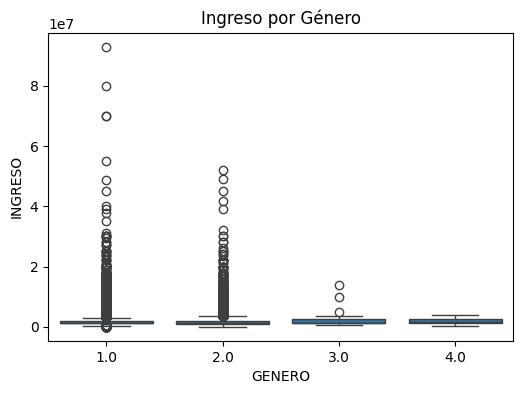

In [17]:
# Regresión ajustada
mod_gen = smf.ols(
    "INGRESO ~ C(GENERO) + EDAD + HORAS_TRABAJO "
    "+ LIMPIEZA_EN_SU_HOGAR_HORAS_DIA + CUIDADO_NINOS_SU_HOGAR_HORAS_DIA "
    "+ CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA + C(ETNIA) + C(DPTO)",
    data=df
).fit()
print(mod_gen.summary())

plt.figure(figsize=(6,4))
sns.boxplot(x='GENERO', y='INGRESO', data=df)
plt.title("Ingreso por Género")
plt.show()

In [18]:
# Disparidades Étnicas (ANOVA) 

print("\n=== 2) Disparidades Étnicas ===")

# Agrupar por ETNIA
grupos_etnia = [g['INGRESO'].dropna().values for _, g in df.groupby('ETNIA')]

# Revisar supuestos
revisar_suposiciones(grupos_etnia, 'Ingreso por Etnia')

# ANOVA o Kruskal
if all(stats.shapiro(g).pvalue > 0.05 for g in grupos_etnia) and stats.levene(*grupos_etnia).pvalue > 0.05:
    F_e, p_e = stats.f_oneway(*grupos_etnia)
    print(f"ANOVA: F={F_e:.3f}, p={p_e:.3f}")
else:
    H, p_kruskal = stats.kruskal(*grupos_etnia)
    print(f"Kruskal-Wallis: H={H:.3f}, p={p_kruskal:.3f}")

# Tukey post-hoc solo si ANOVA es significativa
if p_e < 0.05:
    tukey = pairwise_tukeyhsd(df['INGRESO'], df['ETNIA'], alpha=0.05)
    print(tukey.summary())

plt.figure(figsize=(10,5))
sns.boxplot(x='ETNIA', y='INGRESO', data=df)
plt.xticks(rotation=45)
plt.title("Ingreso por Etnia")
plt.show()


=== 2) Disparidades Étnicas ===

--- Revisión de supuestos para Ingreso por Etnia ---
Grupo 1: Shapiro-W=0.676, p=0.000 (NO normal)
Grupo 2: Shapiro-W=0.974, p=0.919 (normal)
Grupo 3: Shapiro-W=0.582, p=0.000 (NO normal)
Grupo 4: Shapiro-W=0.681, p=0.001 (NO normal)
Grupo 5: Shapiro-W=0.652, p=0.000 (NO normal)
Grupo 6: Shapiro-W=0.497, p=0.000 (NO normal)
Levene test W=10.141, p=0.000 (varianzas distintas)
Kruskal-Wallis: H=399.410, p=0.000


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1840\2978006670.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupos_etnia = [g['INGRESO'].dropna().values for _, g in df.groupby('ETNIA')]
c:\Users\ASUS\anaconda3\envs\analitica\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 54001.
  res = hypotest_fun_out(*samples, **kwds)


NameError: name 'p_e' is not defined


=== 3) Diferencias Regionales ===

--- Revisión de supuestos para Ingreso por Departamento ---
Grupo 1: Shapiro-W=0.516, p=0.000 (NO normal)
Grupo 2: Shapiro-W=0.570, p=0.000 (NO normal)
Grupo 3: Shapiro-W=0.387, p=0.000 (NO normal)
Grupo 4: Shapiro-W=0.551, p=0.000 (NO normal)
Grupo 5: Shapiro-W=0.631, p=0.000 (NO normal)
Grupo 6: Shapiro-W=0.352, p=0.000 (NO normal)
Grupo 7: Shapiro-W=0.724, p=0.000 (NO normal)
Grupo 8: Shapiro-W=0.675, p=0.000 (NO normal)
Grupo 9: Shapiro-W=0.609, p=0.000 (NO normal)
Grupo 10: Shapiro-W=0.401, p=0.000 (NO normal)
Grupo 11: Shapiro-W=0.527, p=0.000 (NO normal)
Grupo 12: Shapiro-W=0.773, p=0.000 (NO normal)
Grupo 13: Shapiro-W=0.523, p=0.000 (NO normal)
Grupo 14: Shapiro-W=0.670, p=0.000 (NO normal)
Grupo 15: Shapiro-W=0.608, p=0.000 (NO normal)
Grupo 16: Shapiro-W=0.495, p=0.000 (NO normal)
Grupo 17: Shapiro-W=0.662, p=0.000 (NO normal)
Grupo 18: Shapiro-W=0.538, p=0.000 (NO normal)
Grupo 19: Shapiro-W=0.570, p=0.000 (NO normal)
Grupo 20: Shapiro-W=

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1840\3512078054.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupos_dpto = [g['INGRESO'].dropna().values for _, g in df.groupby('DPTO')]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1840\3512078054.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('DPTO')['INGRESO'].mean().sort_values().plot(kind='bar')


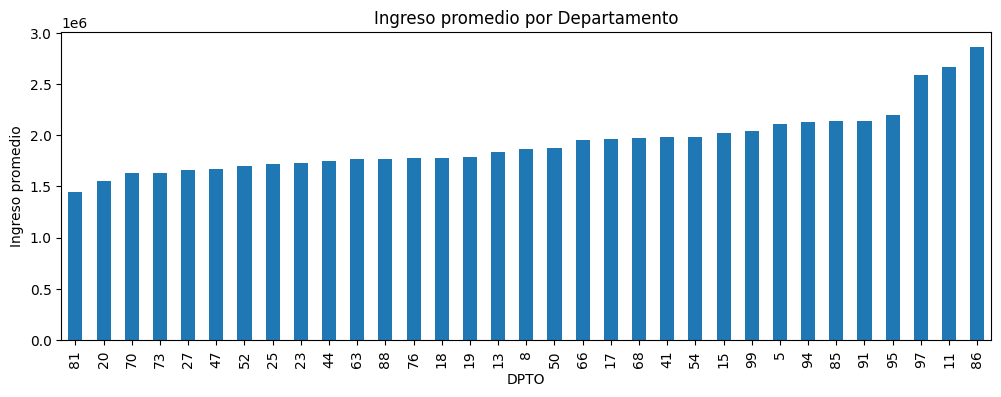

In [19]:
# Diferencias Regionales (DPTO) ---

print("\n=== 3) Diferencias Regionales ===")

grupos_dpto = [g['INGRESO'].dropna().values for _, g in df.groupby('DPTO')]
revisar_suposiciones(grupos_dpto, 'Ingreso por Departamento')

if all(stats.shapiro(g).pvalue > 0.05 for g in grupos_dpto) and stats.levene(*grupos_dpto).pvalue > 0.05:
    F_r, p_r = stats.f_oneway(*grupos_dpto)
    print(f"ANOVA regional: F={F_r:.3f}, p={p_r:.3f}")
else:
    H_r, p_kruskal_r = stats.kruskal(*grupos_dpto)
    print(f"Kruskal-Wallis regional: H={H_r:.3f}, p={p_kruskal_r:.3f}")

plt.figure(figsize=(12,4))
df.groupby('DPTO')['INGRESO'].mean().sort_values().plot(kind='bar')
plt.ylabel("Ingreso promedio")
plt.title("Ingreso promedio por Departamento")
plt.show()

In [20]:
# Chi-square para variables categóricas

print("\n=== 4) Asociación entre Género y Existencia de Contrato ===")

ct = pd.crosstab(df['GENERO'], df['EXISTENCIA_CONTRATO'])
print(ct)

chi2, p_chi, dof, ex = stats.chi2_contingency(ct)
print(f"Chi2 = {chi2:.3f}, p = {p_chi:.3f}")


=== 4) Asociación entre Género y Existencia de Contrato ===
EXISTENCIA_CONTRATO      1
GENERO                    
1.0                  31611
2.0                  28335
3.0                     28
4.0                      7
Chi2 = 0.000, p = 1.000



=== 5) Regresión Ingreso vs Educación ===
                            OLS Regression Results                            
Dep. Variable:                INGRESO   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     1815.
Date:                Sun, 25 May 2025   Prob (F-statistic):               0.00
Time:                        23:42:33   Log-Likelihood:            -9.4353e+05
No. Observations:               59981   AIC:                         1.887e+06
Df Residuals:                   59963   BIC:                         1.887e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

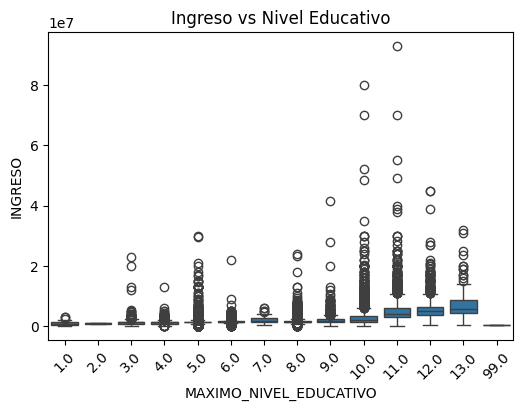

In [21]:
# Modelo regresión(ejemplo con educación)

print("\n=== 5) Regresión Ingreso vs Educación ===")

mod_edu = smf.ols(
    "INGRESO ~ C(MAXIMO_NIVEL_EDUCATIVO) + EDAD + C(GENERO)",
    data=df
).fit()

print(mod_edu.summary())

plt.figure(figsize=(6,4))
sns.boxplot(x='MAXIMO_NIVEL_EDUCATIVO', y='INGRESO', data=df)
plt.xticks(rotation=45)
plt.title("Ingreso vs Nivel Educativo")
plt.show()

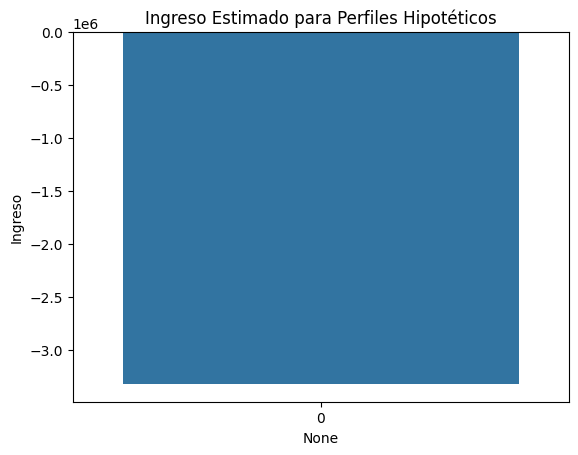

In [22]:
# PERFILES HIPOTÉTICOS
perf = pd.DataFrame([
    {'GENERO': df.GENERO.cat.categories[0],
     'ETNIA':  df.ETNIA.cat.categories[0],
     'EDAD': 17,
     'HORAS_TRABAJO': df['HORAS_TRABAJO'].mean(),
     'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 10,
     'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 10,
     'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 10,
     'DPTO': df.DPTO.cat.categories[0],
     'MAXIMO_NIVEL_EDUCATIVO': df.MAXIMO_NIVEL_EDUCATIVO.cat.categories[-1]
    },
])

for c in ['GENERO','ETNIA','DPTO','MAXIMO_NIVEL_EDUCATIVO']:
    perf[c] = perf[c].astype(df[c].dtype)

perf['PRED_ING'] = mod_gen.predict(perf)

sns.barplot(x=perf.index, y='PRED_ING', data=perf)
plt.title("Ingreso Estimado para Perfiles Hipotéticos")
plt.ylabel("Ingreso")
plt.show()


=== DESCRIPTIVOS POR GÉNERO ===
                      mean     median  count
GENERO                                      
Hombre        1.953647e+06  1300000.0  31611
Hombre trans  2.443429e+06  1300000.0     28
Mujer         1.823504e+06  1300000.0  28335
Mujer trans   1.885714e+06  1500000.0      7 

t-test Género: t = nan, p = nan

=== RESUMEN REGRESIÓN BRECHA DE GÉNERO ===
                            OLS Regression Results                            
Dep. Variable:                INGRESO   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     1.524
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.133
Time:                        23:47:25   Log-Likelihood:                -881.01
No. Observations:                  58   AIC:                             1820.
Df Residuals:                      29   BIC:                       

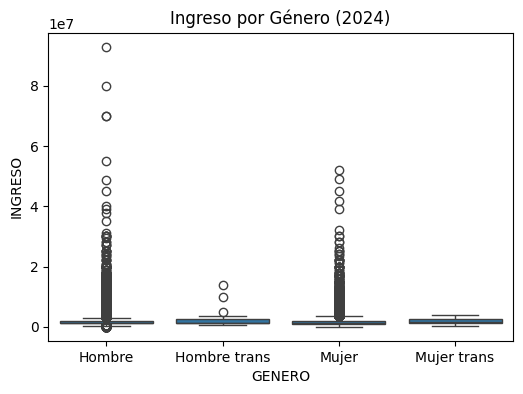

=== MEDIA DE INGRESO POR ETNIA ===
ETNIA
Gitano (Rom)        1.321667e+06
Palenquero          1.386500e+06
Indígena            1.436163e+06
Afrodescendiente    1.620712e+06
Ninguno             1.918088e+06
Raizal              2.068292e+06
Name: INGRESO, dtype: float64 



C:\Users\ASUS\AppData\Local\Temp\ipykernel_1840\4257728550.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('ETNIA')['INGRESO'].mean().sort_values(), "\n")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1840\4257728550.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  F_e, p_e = stats.f_oneway(*[g["INGRESO"].values for _,g in df.groupby('ETNIA')])


ANOVA Étnico → F = nan, p = nan

=== RESULTADOS TUKEY POST-HOC ===
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
     group1         group2    meandiff p-adj lower upper reject
---------------------------------------------------------------
Afrodescendiente Gitano (Rom)      nan   nan   nan   nan  False
Afrodescendiente     Indígena      nan   nan   nan   nan  False
Afrodescendiente      Ninguno      nan   nan   nan   nan  False
Afrodescendiente   Palenquero      nan   nan   nan   nan  False
Afrodescendiente       Raizal      nan   nan   nan   nan  False
    Gitano (Rom)     Indígena      nan   nan   nan   nan  False
    Gitano (Rom)      Ninguno      nan   nan   nan   nan  False
    Gitano (Rom)   Palenquero      nan   nan   nan   nan  False
    Gitano (Rom)       Raizal      nan   nan   nan   nan  False
        Indígena      Ninguno      nan   nan   nan   nan  False
        Indígena   Palenquero      nan   nan   nan   nan  False
        Indígena       Raizal      na

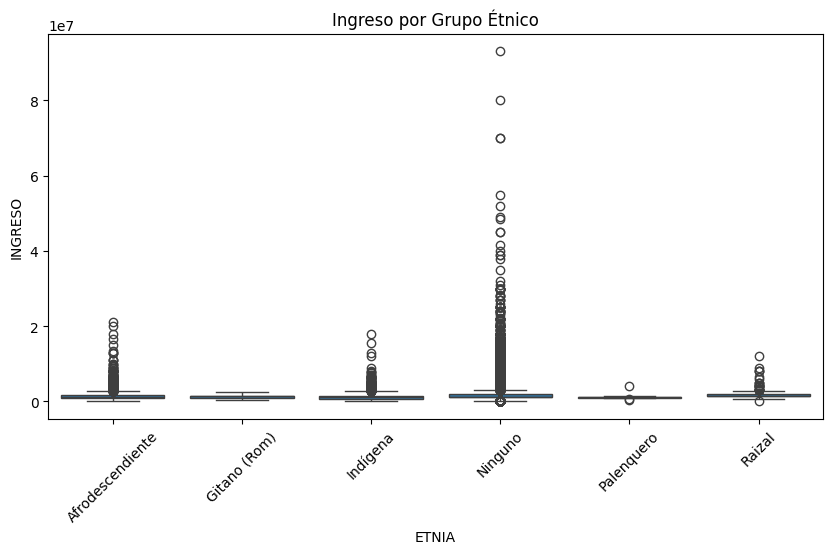

=== INGRESO PROMEDIO POR DPTO ===
DPTO
Cesar                 1.548498e+06
Sucre                 1.615431e+06
Tolima                1.618885e+06
Chocó                 1.653043e+06
Magdalena             1.666515e+06
Nariño                1.680900e+06
Cundinamarca          1.711987e+06
Córdoba               1.721106e+06
La Guajira            1.745510e+06
Caquetá               1.764124e+06
Quindío               1.764857e+06
Valle del Cauca       1.769843e+06
Cauca                 1.776151e+06
Bolívar               1.838612e+06
Atlántico             1.857586e+06
Meta                  1.863273e+06
Risaralda             1.951028e+06
Caldas                1.961592e+06
Santander             1.962683e+06
Huila                 1.974111e+06
Norte de Santander    1.980764e+06
Boyacá                2.011113e+06
Antioquia             2.102143e+06
Bogotá D.C.           2.660368e+06
Name: INGRESO, dtype: float64 



C:\Users\ASUS\AppData\Local\Temp\ipykernel_1840\4257728550.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dept_means = df.groupby('DPTO')['INGRESO'].mean().sort_values()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1840\4257728550.py:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  F_r, p_r = stats.f_oneway(*[g["INGRESO"].values for _,g in df.groupby('DPTO')])


ANOVA Regional → F = nan, p = nan



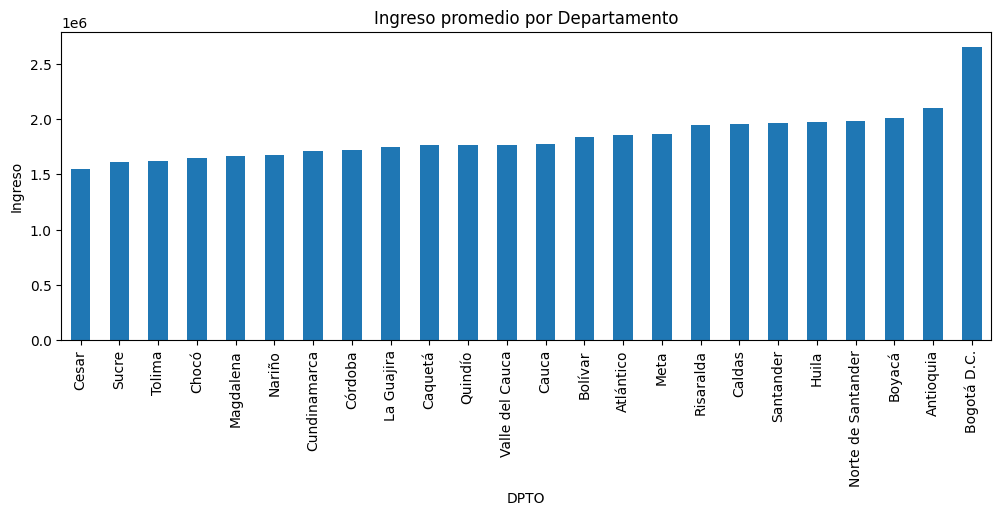

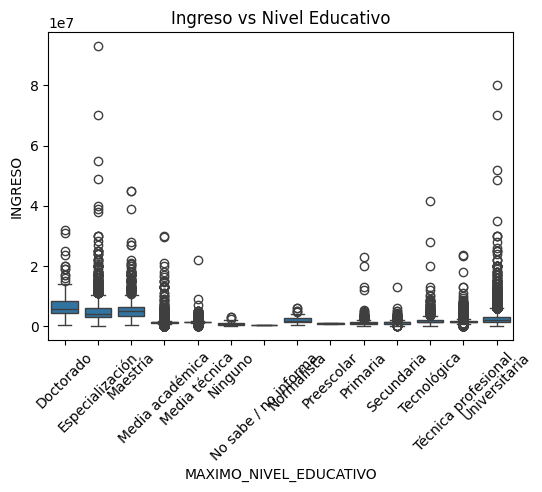

=== COEFICIENTES REGRESIÓN EDUCACIÓN ===
Intercept                                            6.338998e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.Especialización]        -1.989921e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.Maestría]               -1.469451e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.Media académica]        -5.609855e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.Media técnica]          -5.485165e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.Ninguno]                -6.535245e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.No sabe / no informa]   -6.712033e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.Normalista]             -4.920695e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.Preescolar]             -6.492263e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.Primaria]               -6.183873e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.Secundaria]             -5.913919e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.Tecnológica]            -5.047478e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.Técnica profesional]    -5.277174e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.Universitaria]          -4.206706e+06
C(GENERO)[T.Hombre trans]          

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1840\4257728550.py:146: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('SECTOR_AMPLIO')['INGRESO'].mean().sort_values(), "\n")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1840\4257728550.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('EXISTENCIA_CONTRATO')['INGRESO'].mean().sort_values(), "\n")


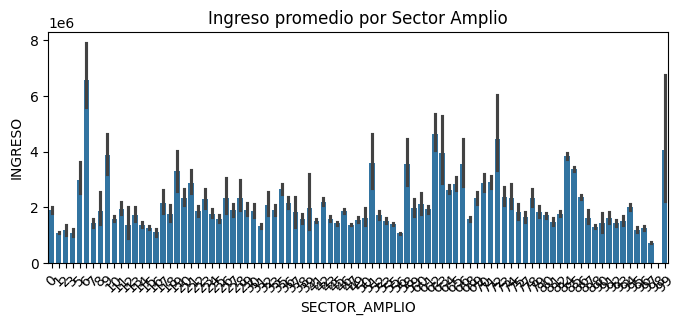

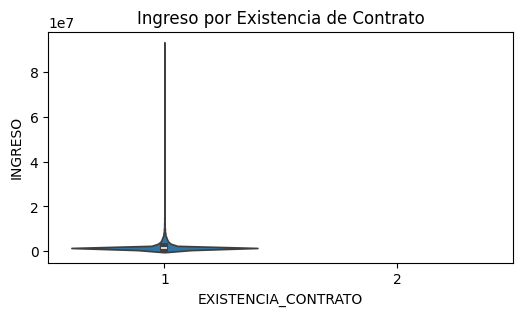

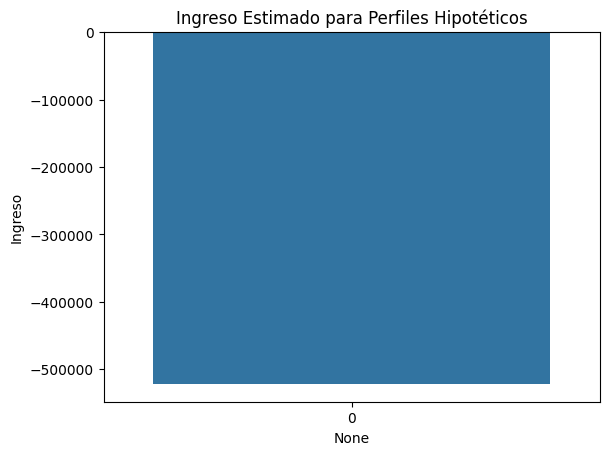

In [33]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Partimos de tu DataFrame final
df = df_total.copy()

# 1) Elimina posibles columnas duplicadas
df = df.loc[:, ~df.columns.duplicated()]

# — después de df = df_final.copy() y antes del for col in [...]
genero_map = {
    1: "Hombre",
    2: "Mujer",
    3: "Hombre trans",
    4: "Mujer trans",
    5: "Otro"
}
etnia_map = {
    1: "Indígena",
    2: "Gitano (Rom)",
    3: "Raizal",
    4: "Palenquero",
    5: "Afrodescendiente",
    6: "Ninguno"
}
dpto_map = {
    5: "Antioquia", 8: "Atlántico", 11: "Bogotá D.C.", 13: "Bolívar", 15: "Boyacá", 17: "Caldas",
    18: "Caquetá", 19: "Cauca", 20: "Cesar", 23: "Córdoba", 25: "Cundinamarca", 27: "Chocó",
    41: "Huila", 44: "La Guajira", 47: "Magdalena", 50: "Meta", 52: "Nariño", 54: "Norte de Santander",
    63: "Quindío", 66: "Risaralda", 68: "Santander", 70: "Sucre", 73: "Tolima", 76: "Valle del Cauca"
}
educ_map = {
    1: "Ninguno", 2: "Preescolar", 3: "Primaria", 4: "Secundaria",
    5: "Media académica", 6: "Media técnica", 7: "Normalista",
    8: "Técnica profesional", 9: "Tecnológica", 10: "Universitaria",
    11: "Especialización", 12: "Maestría", 13: "Doctorado", 99: "No sabe / no informa"
}

# Aplica los mapeos en df
if 'GENERO' in df.columns:
    df['GENERO'] = df['GENERO'].map(genero_map)
if 'ETNIA' in df.columns:
    df['ETNIA'] = df['ETNIA'].map(etnia_map)
if 'DPTO' in df.columns:
    df['DPTO'] = df['DPTO'].map(dpto_map)
if 'MAXIMO_NIVEL_EDUCATIVO' in df.columns:
    df['MAXIMO_NIVEL_EDUCATIVO'] = df['MAXIMO_NIVEL_EDUCATIVO'].map(educ_map)



# 2) Renombra DPTO_x si lo necesitas y crea una única columna DPTO
if 'DPTO_x' in df.columns:
    df = df.rename(columns={'DPTO_x':'DPTO'})
elif 'DPTO' not in df.columns:
    raise KeyError("No se encontró ninguna columna DPTO_x ni DPTO en df_final")

# 3) Convierte a categóricas las variables que lo requieran
for col in ['GENERO','ETNIA','DPTO','MAXIMO_NIVEL_EDUCATIVO','SECTOR_AMPLIO','EXISTENCIA_CONTRATO']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# -----------------------------------------------------------------------------
# 1) BRECHA DE GÉNERO
# -----------------------------------------------------------------------------
print("=== DESCRIPTIVOS POR GÉNERO ===")
print(df.groupby('GENERO', observed=True)['INGRESO'].agg(['mean','median','count']), "\n")

# T-test Hombres vs Mujeres (ajusta códigos si no son 1 y 2)
df_m = df[df.GENERO == df.GENERO.cat.categories[1]]['INGRESO']
df_f = df[df.GENERO == df.GENERO.cat.categories[0]]['INGRESO']
t, p = stats.ttest_ind(df_m, df_f, equal_var=False)
print(f"t-test Género: t = {t:.2f}, p = {p:.3f}\n")

mod_gen = smf.ols(
    "INGRESO ~ C(GENERO) + EDAD + HORAS_TRABAJO "
    "+ LIMPIEZA_EN_SU_HOGAR_HORAS_DIA + CUIDADO_NINOS_SU_HOGAR_HORAS_DIA "
    "+ CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA + C(ETNIA) + C(DPTO)",
    data=df
).fit()
print("=== RESUMEN REGRESIÓN BRECHA DE GÉNERO ===")
print(mod_gen.summary(), "\n")

plt.figure(figsize=(6,4))
sns.boxplot(x='GENERO', y='INGRESO', data=df)
plt.title("Ingreso por Género (2024)")
plt.show()

# -----------------------------------------------------------------------------
# 2) DISPARIDADES ÉTNICAS
# -----------------------------------------------------------------------------
print("=== MEDIA DE INGRESO POR ETNIA ===")
print(df.groupby('ETNIA')['INGRESO'].mean().sort_values(), "\n")

F_e, p_e = stats.f_oneway(*[g["INGRESO"].values for _,g in df.groupby('ETNIA')])
print(f"ANOVA Étnico → F = {F_e:.2f}, p = {p_e:.3f}\n")

tukey = pairwise_tukeyhsd(df['INGRESO'], df['ETNIA'], alpha=0.05)
print("=== RESULTADOS TUKEY POST-HOC ===")
print(tukey.summary(), "\n")

plt.figure(figsize=(10,5))
sns.boxplot(x='ETNIA', y='INGRESO', data=df)
plt.xticks(rotation=45)
plt.title("Ingreso por Grupo Étnico")
plt.show()

# -----------------------------------------------------------------------------
# 3) DIFERENCIAS REGIONALES
# -----------------------------------------------------------------------------
print("=== INGRESO PROMEDIO POR DPTO ===")
dept_means = df.groupby('DPTO')['INGRESO'].mean().sort_values()
print(dept_means, "\n")

F_r, p_r = stats.f_oneway(*[g["INGRESO"].values for _,g in df.groupby('DPTO')])
print(f"ANOVA Regional → F = {F_r:.2f}, p = {p_r:.3f}\n")

dept_means.plot(kind='bar', figsize=(12,4), title="Ingreso promedio por Departamento")
plt.ylabel("Ingreso")
plt.show()

# -----------------------------------------------------------------------------
# 4) IMPACTO EDUCATIVO
# -----------------------------------------------------------------------------
plt.figure(figsize=(6,4))
sns.boxplot(x='MAXIMO_NIVEL_EDUCATIVO', y='INGRESO', data=df)
plt.xticks(rotation=45)
plt.title("Ingreso vs Nivel Educativo")
plt.show()

mod_edu = smf.ols(
    "INGRESO ~ C(MAXIMO_NIVEL_EDUCATIVO) + EDAD + C(GENERO)",
    data=df
).fit()
print("=== COEFICIENTES REGRESIÓN EDUCACIÓN ===")
print(mod_edu.params, "\n")

# -----------------------------------------------------------------------------
# 5) PRIMAS OCUPACIONALES
# -----------------------------------------------------------------------------
print("=== INGRESO POR SECTOR_AMPLIO ===")
print(df.groupby('SECTOR_AMPLIO')['INGRESO'].mean().sort_values(), "\n")

print("=== INGRESO POR EXISTENCIA_CONTRATO ===")
print(df.groupby('EXISTENCIA_CONTRATO')['INGRESO'].mean().sort_values(), "\n")

plt.figure(figsize=(8,3))
sns.barplot(x='SECTOR_AMPLIO', y='INGRESO', data=df)
plt.xticks(rotation=45)
plt.title("Ingreso promedio por Sector Amplio")
plt.show()

plt.figure(figsize=(6,3))
sns.violinplot(x='EXISTENCIA_CONTRATO', y='INGRESO', data=df)
plt.title("Ingreso por Existencia de Contrato")
plt.show()

# -----------------------------------------------------------------------------
# 6) PERFILES HIPOTÉTICOS
# -----------------------------------------------------------------------------
perf = pd.DataFrame([
    {'GENERO': df.GENERO.cat.categories[0],
     'ETNIA':  df.ETNIA.cat.categories[0],
     'EDAD': 17,
     'HORAS_TRABAJO': df['HORAS_TRABAJO'].mean(),
     'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 10,
     'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 10,
     'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 10,
     'DPTO': df.DPTO.cat.categories[0],
     'MAXIMO_NIVEL_EDUCATIVO': df.MAXIMO_NIVEL_EDUCATIVO.cat.categories[-1]
    },
    # … agrega más perfiles según necesites …
])

# Asegura mismas categorías
for c in ['GENERO','ETNIA','DPTO','MAXIMO_NIVEL_EDUCATIVO']:
    perf[c] = perf[c].astype(df[c].dtype)

perf['PRED_ING'] = mod_gen.predict(perf)

sns.barplot(x=perf.index, y='PRED_ING', data=perf)
plt.title("Ingreso Estimado para Perfiles Hipotéticos")
plt.ylabel("Ingreso")
plt.show()


In [34]:
# Inspeccionar categorías
print("GENERO:", df.GENERO.cat.categories.tolist())
print("ETNIA:", df.ETNIA.cat.categories.tolist())
print("DPTO:", df.DPTO.cat.categories.tolist())
print("MAXIMO_NIVEL_EDUCATIVO:", df.MAXIMO_NIVEL_EDUCATIVO.cat.categories.tolist())

# Asignar directamente los códigos según tu esquema
# ETNIA: 1=Indígena, 5=Afro, 6=Ninguno de los anteriores (asumimos 'blanco/mestizo')
etnia_nativa         = 1
etnia_afro           = 5
etnia_blanco_mestizo = 6

# DPTO: 8=Atlántico, 11=Bogotá, 50=Meta
dpto_atlantico = 8
dpto_bogota    = 11
dpto_meta      = 50

# MAXIMO_NIVEL_EDUCATIVO (ejemplo): 
# 1=Ninguno, 2=Primaria, 3=Secundaria, 4=Técnico, 5=Profesional, 6=Posgrado
edu_sin          = 1
edu_bachillerato = 3
edu_profesional  = 5

# Definir perfiles
perfiles = [
    {
        'nombre': 'Mujer nativa Caribe 17a',
        'GENERO': df.GENERO.cat.categories[0],  
        'ETNIA': etnia_nativa,
        'EDAD': 17,
        'HORAS_TRABAJO': df['HORAS_TRABAJO'].mean(),
        'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 10,
        'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 10,
        'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 10,
        'DPTO': dpto_atlantico,
        'MAXIMO_NIVEL_EDUCATIVO': edu_profesional
    },
    {
        'nombre': 'Hombre 17a Bogotá adinerado',
        'GENERO': df.GENERO.cat.categories[1],
        'ETNIA': etnia_blanco_mestizo,
        'EDAD': 17,
        'HORAS_TRABAJO': df['HORAS_TRABAJO'].mean(),
        'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 2,
        'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 2,
        'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 0,
        'DPTO': dpto_bogota,
        'MAXIMO_NIVEL_EDUCATIVO': edu_profesional
    },
    {
        'nombre': 'Mujer 17a Bogotá sin uni',
        'GENERO': df.GENERO.cat.categories[0],
        'ETNIA': etnia_blanco_mestizo,
        'EDAD': 17,
        'HORAS_TRABAJO': df['HORAS_TRABAJO'].mean(),
        'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 2,
        'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 2,
        'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 0,
        'DPTO': dpto_bogota,
        'MAXIMO_NIVEL_EDUCATIVO': edu_bachillerato
    },
    {
        'nombre': 'Madre cabeza familia Villavicencio 30a',
        'GENERO': df.GENERO.cat.categories[0],
        'ETNIA': etnia_afro,
        'EDAD': 30,
        'HORAS_TRABAJO': df['HORAS_TRABAJO'].mean(),
        'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 5,
        'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 8,
        'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 2,
        'DPTO': dpto_meta,
        'MAXIMO_NIVEL_EDUCATIVO': edu_bachillerato
    }
]

# 4) Construir DataFrame y ajustar tipos
perf = pd.DataFrame(perfiles)
for c in ['GENERO','ETNIA','DPTO','MAXIMO_NIVEL_EDUCATIVO']:
    perf[c] = perf[c].astype(df[c].dtype)

# 5) Predecir ingresos
perf['PRED_ING_GEN'] = mod_gen.predict(perf)
perf['PRED_ING_EDU'] = mod_edu.predict(perf)

# 6) Resultados
print(perf[['nombre','PRED_ING_GEN','PRED_ING_EDU']])


GENERO: ['Hombre', 'Hombre trans', 'Mujer', 'Mujer trans']
ETNIA: ['Afrodescendiente', 'Gitano (Rom)', 'Indígena', 'Ninguno', 'Palenquero', 'Raizal']
DPTO: ['Antioquia', 'Atlántico', 'Bogotá D.C.', 'Bolívar', 'Boyacá', 'Caldas', 'Caquetá', 'Cauca', 'Cesar', 'Chocó', 'Cundinamarca', 'Córdoba', 'Huila', 'La Guajira', 'Magdalena', 'Meta', 'Nariño', 'Norte de Santander', 'Quindío', 'Risaralda', 'Santander', 'Sucre', 'Tolima', 'Valle del Cauca']
MAXIMO_NIVEL_EDUCATIVO: ['Doctorado', 'Especialización', 'Maestría', 'Media académica', 'Media técnica', 'Ninguno', 'No sabe / no informa', 'Normalista', 'Preescolar', 'Primaria', 'Secundaria', 'Tecnológica', 'Técnica profesional', 'Universitaria']
                                   nombre  PRED_ING_GEN  PRED_ING_EDU
0                 Mujer nativa Caribe 17a           NaN           NaN
1             Hombre 17a Bogotá adinerado           NaN           NaN
2                Mujer 17a Bogotá sin uni           NaN           NaN
3  Madre cabeza familia Vi

### **Sección 3:  Procesamiento de Datos**

In [35]:
vars_num = [
    'INGRESO',
    'EDAD',
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]

# 2) Calcula los límites y cuenta outliers
outliers_summary = []
for col in vars_num:
    serie = df[col].dropna()
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (serie < lower) | (serie > upper)
    n_out = mask.sum()
    outliers_summary.append({
        'Variable': col,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Límite inferior': lower,
        'Límite superior': upper,
        'Nº outliers': int(n_out)
    })

outliers_df = pd.DataFrame(outliers_summary)
print(outliers_df)

                             Variable         Q1         Q3       IQR  \
0                             INGRESO  1200000.0  2000000.0  800000.0   
1                                EDAD       30.0       52.0      22.0   
2                       HORAS_TRABAJO       40.0       48.0       8.0   
3      LIMPIEZA_EN_SU_HOGAR_HORAS_DIA        1.0        2.0       1.0   
4    CUIDADO_NINOS_SU_HOGAR_HORAS_DIA        2.0        6.0       4.0   
5  CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA        2.0        6.0       4.0   

   Límite inferior  Límite superior  Nº outliers  
0              0.0        3200000.0         6832  
1             -3.0             85.0           58  
2             28.0             60.0        18770  
3             -0.5              3.5         3440  
4             -4.0             12.0          615  
5             -4.0             12.0          132  


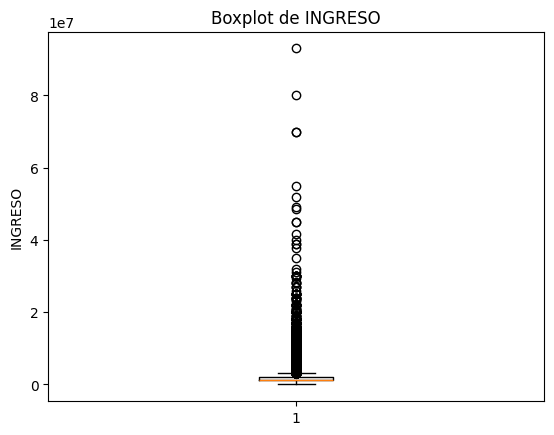

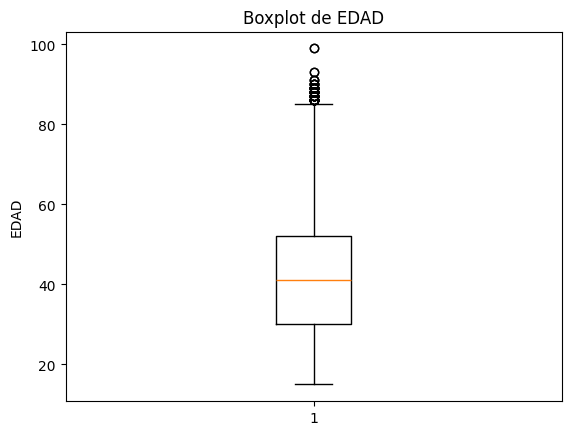

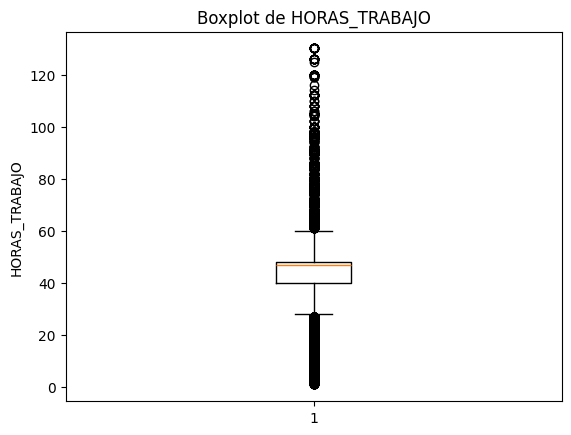

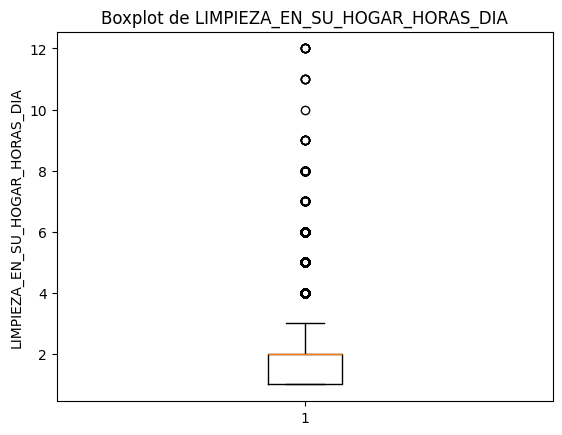

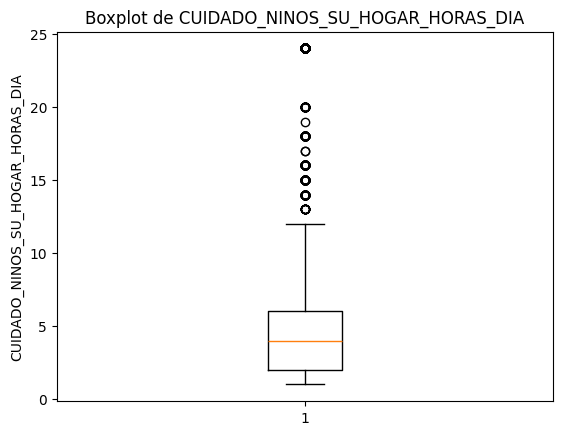

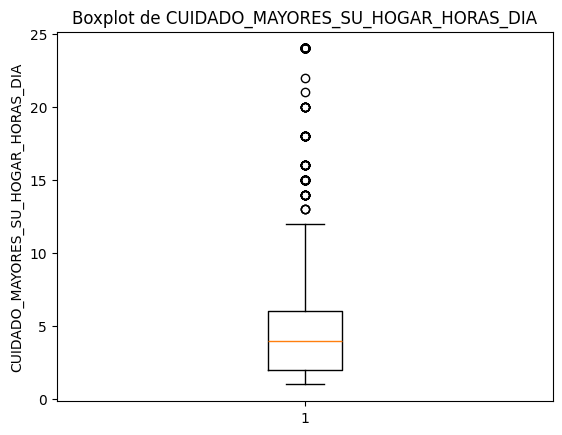

In [36]:
for var in vars_num:
    serie = df[var].dropna()
    plt.figure()
    plt.boxplot(serie)
    plt.title(f"Boxplot de {var}")
    plt.ylabel(var)
    plt.show()

In [37]:
# OUTLIERS DE HORAS(posiblemente negativos)
cols_horas = [
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]

for col in cols_horas:
    n_neg = (df[col] < 0).sum()
    print(f"{col}: {n_neg} valores negativos")


HORAS_TRABAJO: 0 valores negativos
LIMPIEZA_EN_SU_HOGAR_HORAS_DIA: 0 valores negativos
CUIDADO_NINOS_SU_HOGAR_HORAS_DIA: 0 valores negativos
CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA: 0 valores negativos


In [38]:
# OUTLIERS DE EDAD

# Límite superior calculado
limite_sup = df['EDAD'].quantile(0.75) + 1.5 * (df['EDAD'].quantile(0.75) - df['EDAD'].quantile(0.25))
print("Límite superior para outliers en EDAD:", limite_sup)

# Filtrar edades > límite
edades_muy_altas = df[df['EDAD'] > limite_sup]

# Cuántas son y muestras
print(f"Total de casos con EDAD > {limite_sup:.1f} años:", edades_muy_altas.shape[0])
print(edades_muy_altas[['EDAD']].sort_values('EDAD').head(10))


Límite superior para outliers en EDAD: 85.0
Total de casos con EDAD > 85.0 años: 58
        EDAD
4213      86
11823     86
18375     86
20876     86
27329     86
57426     86
50422     86
41291     86
79720     86
105034    86


Resumen de log(INGRESO + 1):
count    59981.000000
mean        14.180179
std          0.786668
min          0.000000
25%         14.038655
50%         14.077876
75%         14.508658
max         18.348110
Name: log_INGRESO, dtype: float64


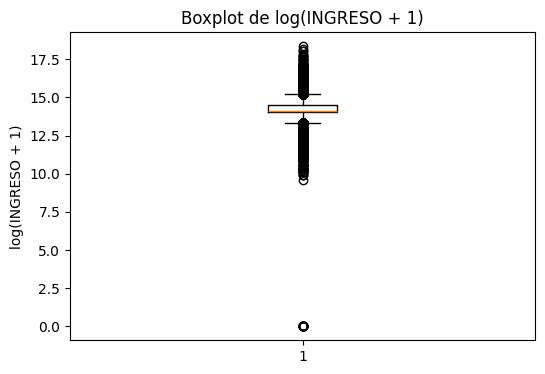

In [39]:
# 1) Transformación logarítmica de INGRESO
df_final['log_INGRESO'] = np.log1p(df_final['INGRESO'])

# 2) Resumen estadístico
print("Resumen de log(INGRESO + 1):")
print(df_final['log_INGRESO'].describe())

# 3) Boxplot para visualizar outliers en escala log
plt.figure(figsize=(6,4))
plt.boxplot(df_final['log_INGRESO'].dropna())
plt.title("Boxplot de log(INGRESO + 1)")
plt.ylabel("log(INGRESO + 1)")
plt.show()

In [40]:
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------
# 1. Mapeo de variables categóricas legibles (si existen)
# ----------------------------------------------------------

# ETNIA
if 'ETNIA' in df.columns:
    etnia_map = {
        1: "Indígena",
        2: "Gitano (Rom)",
        3: "Raizal",
        4: "Palenquero",
        5: "Afrodescendiente",
        6: "Ninguno"
    }
    df['ETNIA'] = df['ETNIA'].map(etnia_map).astype('category')

# GENERO
if 'GENERO' in df.columns:
    genero_map = {
        1: "Hombre",
        2: "Mujer",
        3: "Hombre trans",
        4: "Mujer trans",
        5: "Otro"
    }
    df['GENERO'] = df['GENERO'].map(genero_map).astype('category')

# DPTO
if 'DPTO' in df.columns:
    dpto_map = {
        5: "Antioquia", 8: "Atlántico", 11: "Bogotá D.C.", 13: "Bolívar", 15: "Boyacá", 17: "Caldas",
        18: "Caquetá", 19: "Cauca", 20: "Cesar", 23: "Córdoba", 25: "Cundinamarca", 27: "Chocó",
        41: "Huila", 44: "La Guajira", 47: "Magdalena", 50: "Meta", 52: "Nariño", 54: "Norte de Santander",
        63: "Quindío", 66: "Risaralda", 68: "Santander", 70: "Sucre", 73: "Tolima", 76: "Valle del Cauca"
    }
    df['DPTO'] = df['DPTO'].map(dpto_map).astype('category')

# Nivel educativo
if 'MAXIMO_NIVEL_EDUCATIVO' in df.columns:
    educ_map = {
        1: "Ninguno",
        2: "Preescolar",
        3: "Primaria",
        4: "Secundaria",
        5: "Media académica",
        6: "Media técnica",
        7: "Normalista",
        8: "Técnica profesional",
        9: "Tecnológica",
        10: "Universitaria",
        11: "Especialización",
        12: "Maestría",
        13: "Doctorado",
        99: "No sabe / no informa"
    }
    df['MAXIMO_NIVEL_EDUCATIVO'] = df['MAXIMO_NIVEL_EDUCATIVO'].map(educ_map).astype('category')


In [41]:
#a

### **Sección 4: Modelado Predictivo y Evaluación**

Hasta Aqui vamos...

Lo que continua es solo referencia por si algo pasa ok? jaja

In [ ]:
# Solo si aparece:
df_total = df_total.rename(columns={'P6500':'INGRESO'})
print('INGRESO' in df_total.columns)   # debe ser True


True


In [ ]:
import sys
!{sys.executable} -m pip install --upgrade matplotlib seaborn

In [ ]:
import pandas as pd

# 1) Subconjunto con las variables numéricas
num_vars = [
    "ingreso_mensual", "ingreso_horas_extras", "pago_especie_alimentos",
    "pago_especie_vivienda", "pago_especie_otros", "subsidio_alimentacion",
    "subsidio_transporte", "subsidio_familiar", "subsidio_educativo",
    "prima_navidad", "prima_vacaciones", "bonificacion_antiguedad",
    "bonificacion_productividad", "bonificacion_riesgo",
    "bonificacion_permanencia", "viaticos",
    "sexo",  "edad",  "etnia",  "departamento", "area_residencia",
    "tipo_cabecera", "nivel_educativo", "grado_nivel_educativo",
    "campo_estudio", "titulo_obtenido", "modalidad_titulo",
    "tiene_contrato", "contrato_escrito", "tipo_contrato",
    "medio_obtencion_empleo", "empresa_con_contabilidad",
    "forma_trabajo_semana", "lugar_nacimiento", "nacionalidad_exterior",
    "residencia_5m", "residencia_12m", "residencia_5a",
    "ingreso_arriendos_pensiones", "cesantias_derecho",
    "impuesto_predial", "impuesto_valorizacion", "impuesto_renta",
]

df_num = df_anual[num_vars].copy()

# 2) Describe: media, std, min, 25%, 50%, 75%, max
desc = df_num.describe().T

# 3) Añadimos sesgo (skewness) y curtosis (kurtosis)
desc["skewness"] = df_num.skew()
desc["kurtosis"] = df_num.kurt()

# 4) Mostramos todo
display(desc)


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
ingreso_mensual,183735.0,1.889567e+06,2.061834e+06,0.0,1200000.0,1300000.0,1950000.0,100000000.0,9.087785,200.857188
ingreso_horas_extras,187431.0,1.981887e+00,3.582363e-01,1.0,2.0,2.0,2.0,9.0,14.185536,289.592188
pago_especie_alimentos,187431.0,1.924564e+00,4.555023e-01,1.0,2.0,2.0,2.0,9.0,8.447657,141.767856
pago_especie_vivienda,187431.0,1.982762e+00,3.255414e-01,1.0,2.0,2.0,2.0,9.0,15.144028,342.622511
pago_especie_otros,187431.0,2.002721e+00,2.381773e-01,1.0,2.0,2.0,2.0,9.0,26.570314,789.418745
subsidio_alimentacion,187431.0,1.992936e+00,3.084698e-01,1.0,2.0,2.0,2.0,9.0,17.845304,418.014787
subsidio_transporte,187431.0,1.586765e+00,6.316905e-01,1.0,1.0,2.0,2.0,9.0,4.329758,50.455306
subsidio_familiar,187431.0,1.897285e+00,4.364210e-01,1.0,2.0,2.0,2.0,9.0,6.578901,122.210957
subsidio_educativo,187431.0,2.005501e+00,2.422939e-01,1.0,2.0,2.0,2.0,9.0,27.415262,794.404174
prima_navidad,187431.0,2.000208e+00,2.778047e-01,1.0,2.0,2.0,2.0,9.0,21.663842,555.592637


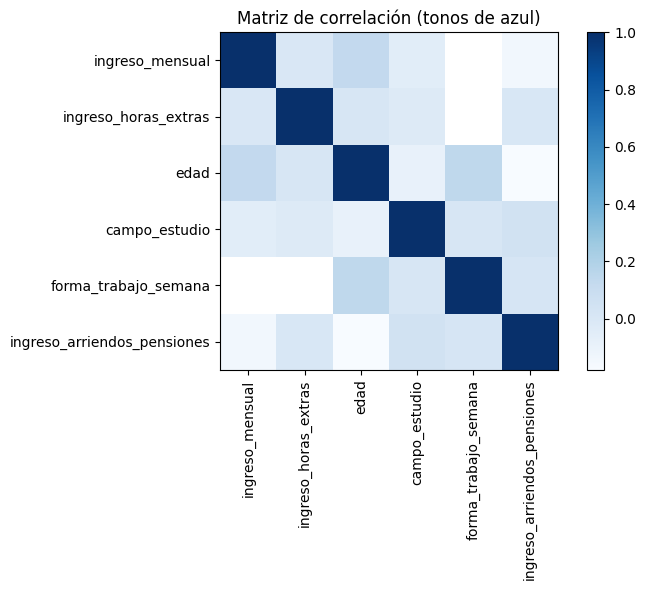

In [ ]:

corr = df_anual.select_dtypes(include=['int64','float64']).corr()
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr, cmap='Blues', interpolation='nearest')
fig.colorbar(cax)

ax.set_xticks(range(len(corr)))
ax.set_yticks(range(len(corr)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
ax.set_title('Matriz de correlación (tonos de azul)')
plt.tight_layout()
plt.show()

In [ ]:
Q1 = df_anual['ingreso_mensual'].quantile(0.25)
Q3 = df_anual['ingreso_mensual'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQRs
upper = Q3 + 1.5 * IQR

outliers = df_anual[
    (df_anual['ingreso_mensual'] < lower) |
    (df_anual['ingreso_mensual'] > upper)
]
print(f"Número de outliers por IQR: {outliers.shape[0]}")


Número de outliers por IQR: 22677


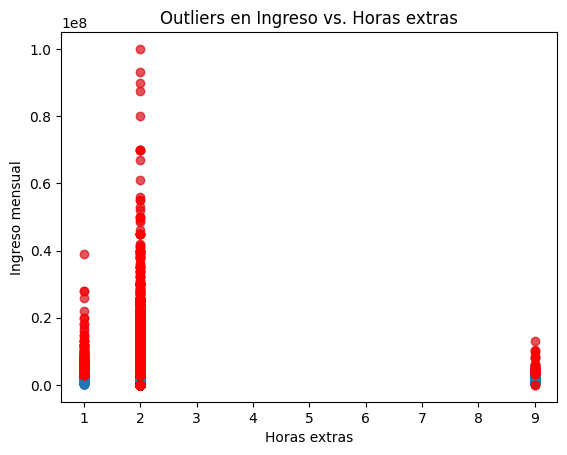

In [ ]:
plt.scatter(df_anual['ingreso_horas_extras'], df_anual['ingreso_mensual'], alpha=0.3)
plt.scatter(outliers['ingreso_horas_extras'], outliers['ingreso_mensual'], color='red', alpha=0.6)
plt.xlabel('Horas extras')
plt.ylabel('Ingreso mensual')
plt.title('Outliers en Ingreso vs. Horas extras')
plt.show()